In [1]:
#@title Librerias necesarias
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_theme()

In [ ]:
#@title Visualizar los mapas de profundidad
#@markdown Este metodo se saco del codigo de github del dataset
import numpy as np
import matplotlib
import matplotlib.cm as cm
import cv2

def visualize_depth_as_numpy(depth, cmap="jet", is_sparse=True):
    """
    Args:
        data (HxW): depth data
        cmap: color map (inferno, plasma, jet, turbo, magma, rainbow)
    Returns:
        vis_data (HxWx3): depth visualization (RGB)
    """

    # x = depth.cpu().numpy()
    x = np.nan_to_num(depth)  # change nan to 0

    inv_depth = 1 / (x + 1e-6)

    if is_sparse:
        vmax = 1 / np.percentile(x[x != 0], 5)
    else:
        vmax = np.percentile(inv_depth, 95)

    normalizer = matplotlib.colors.Normalize(vmin=inv_depth.min(), vmax=vmax)
    mapper = cm.ScalarMappable(norm=normalizer, cmap=cmap)
    vis_data = (mapper.to_rgba(inv_depth)[:, :, :3] * 255).astype(np.uint8)
    if is_sparse:
        vis_data[inv_depth > vmax] = 0
    return vis_data

In [ ]:
#@title Montar el drive
drive.mount("/content/gdrive")
%cd "/content/gdrive/MyDrive/Procesamiento de imagenes/Proyecto Final/Depth-Estimation-with-StereoThermal-Images/FIReStereo_sample_dataset/stereo_thermal_depth/frick_1"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Procesamiento de imagenes/Proyecto Final/Depth-Estimation-with-StereoThermal-Images/FIReStereo_sample_dataset/stereo_thermal_depth/frick_1


# 1. Exploración de los datos

In [ ]:
#@title Carga de imagenes termicas
## Nombre de los documentos
images_name = np.asarray(['00906.png', '01220.png', '01504.png', '01605.png', '01810.png'])

## Listas para guardar las imagenes
image_left = []
image_right = []

## Leer imagenes
for i in images_name:
  image_left.append(cv2.imread(f"img_left/{i}", cv2.IMREAD_UNCHANGED))
  image_right.append(cv2.imread(f"img_right/{i}", cv2.IMREAD_UNCHANGED))

## Graficar/mostrar las imagenes
for i, (j, k) in enumerate(zip(image_left, image_right)):
  plt.figure(figsize=[15,18])
  plt.subplot(121)
  plt.imshow(j)
  plt.title(f"{i+1}.Imagen de la izquierda")
  plt.axis('off')
  plt.subplot(122)
  plt.imshow(k)
  plt.title(f"{i+1}.Imagen de la derecha")
  plt.axis('off')
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#@title Caracteristicas de las imagenes

print('--'*30)

print("Imagen izquierda")
print('Profundidad de Bits: ', image_left[0].dtype)
print("Valor maximo = ", image_left[0].max(), "Valor minimo = ", image_left[0].min())
print('Tamaño: ', image_left[0].shape)

print("Imagen derecha")
print('Profundidad de Bits: ', image_right[0].dtype)
print("Valor maximo = ", image_right[0].max(), "Valor minimo = ", image_right[0].min())
print('Tamaño: ', image_left[0].shape)

print('--'*30)

------------------------------------------------------------
Imagen izquierda
Profundidad de Bits:  uint16
Valor maximo =  22255 Valor minimo =  21765
Tamaño:  (512, 640)
Imagen derecha
Profundidad de Bits:  uint16
Valor maximo =  21783 Valor minimo =  21276
Tamaño:  (512, 640)
------------------------------------------------------------


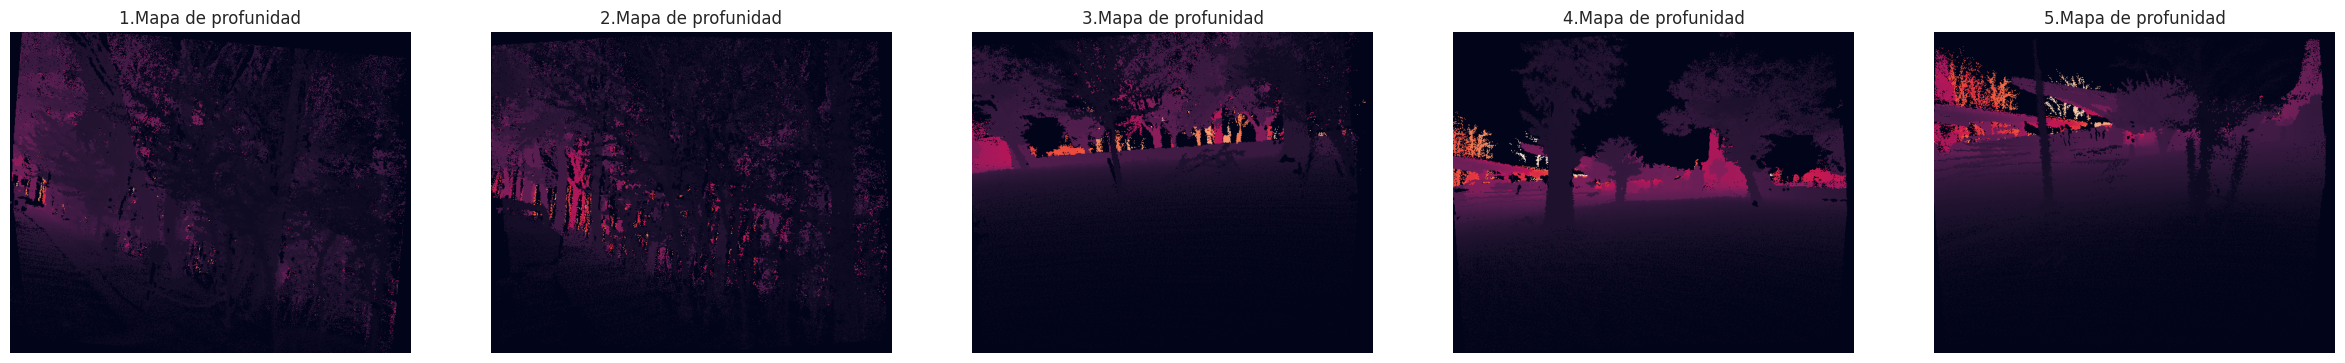

In [ ]:
#@title Carga de los mapas de profundidad
## Listas para guardar los mapas
depth = []

## Leer mapas de profundidad
for i in images_name:
  depth.append(cv2.imread(f"depth_filtered/{i}", cv2.IMREAD_UNCHANGED))

## Graficar/mostrar los mapas
plt.figure(figsize=(30,100))
for i, j in enumerate(depth):
  plt.subplot(1,5,i+1)
  plt.imshow(j)
  plt.title(f"{i+1}.Mapa de profunidad")
  plt.axis('off')

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
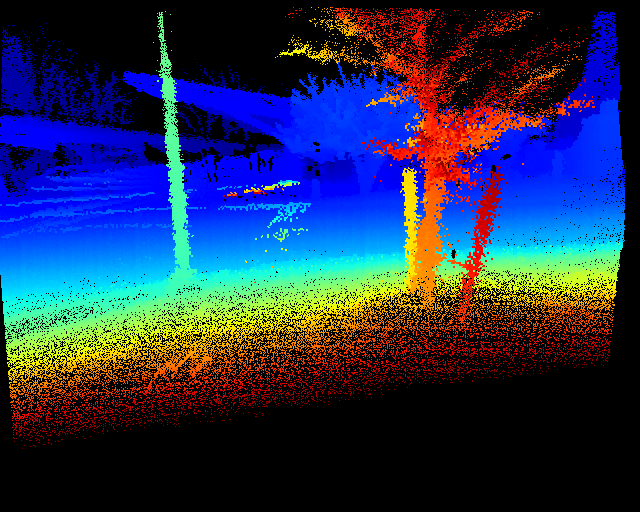

In [ ]:
#@title Visualizar los mapas
visualize_depth_as_numpy(depth[4])

In [ ]:
#@title Caracteristicas de los mapas de pronfidad
print('--'*30)

print("Mapa de profundida")
print('Profundidad de Bits: ', depth[0].dtype)
print("Valor maximo = ", depth[0].max(), "Valor minimo = ", depth[0].min())
print('Tamaño: ', depth[0].shape)

print('--'*30)

------------------------------------------------------------
Mapa de profundida
Profundidad de Bits:  uint16
Valor maximo =  23971 Valor minimo =  0
Tamaño:  (512, 640)
------------------------------------------------------------


# 2. Preparación de las imagenes

In [ ]:
## Normalizar los datos
image_left_norm = [(i -i.min()) / (i.max() - i.min()) for i in image_left]
image_right_norm = [(i -i.min()) / (i.max() - i.min()) for i in image_right]

for i, (imgL, imgR) in enumerate(zip(image_left_norm, image_right_norm)):
  print('--'*30)
  print('Valores normalizados:')
  print(f'Par de imagenes {i+1}: left(min: {imgL.min()}, max: {imgL.max()}), right(min: {imgL.min()}, max: {imgL.max()})')

## Parametros de calibracion intrinsecos y extrinsecos


------------------------------------------------------------
Valores normalizados:
Par de imagenes 1: left(min: 0.0, max: 1.0), right(min: 0.0, max: 1.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 2: left(min: 0.0, max: 1.0), right(min: 0.0, max: 1.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 3: left(min: 0.0, max: 1.0), right(min: 0.0, max: 1.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 4: left(min: 0.0, max: 1.0), right(min: 0.0, max: 1.0)
------------------------------------------------------------
Valores normalizados:
Par de imagenes 5: left(min: 0.0, max: 1.0), right(min: 0.0, max: 1.0)
